In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import os
import warnings

In [28]:
# SECTION 1 — Load data
CSV_PATH = "../data/starwars/starwars_mocloose_sales_202510061222.csv"  # <-- adjust if needed
assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH, low_memory=False)

# Best-effort parse for any datetime-like columns (keeps code portable)
for c in df.columns:
    if any(k in c.lower() for k in ["date", "time", "timestamp"]):
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce")
        except Exception:
            pass

print(f"Rows: {len(df):,} • Cols: {df.shape[1]}")
df.head(10)


Rows: 52,062 • Cols: 7


,figure,authenticity_n,selling_price,sales,condition,character_type,year
0,2-1B,0,8.59,0.4,loose_figure,droid,2013
1,2-1B,0,10.58,0.4,loose_figure,droid,2013
2,2-1B,0,9.58,0.4,loose_figure,droid,2013
3,2-1B,0,9.58,0.4,loose_figure,droid,2013
4,2-1B,0,10.58,0.4,loose_figure,droid,2013
5,2-1B,0,9.58,0.4,loose_figure,droid,2013
6,2-1B,0,10.58,0.4,loose_figure,droid,2013
7,2-1B,0,8.59,0.4,loose_figure,droid,2013
8,2-1B,0,8.59,0.4,loose_figure,droid,2013
9,2-1B,0,13.14,0.4,loose_figure,droid,2013


In [29]:
# SECTION 1 — Schema & missingness
print("\nData types:")
print(df.dtypes)

schema = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "missing": df.isna().sum(),
})
schema["missing_pct"] = (schema["missing"] / len(df) * 100).round(2)

schema.sort_values("missing", ascending=False)



Data types:
figure             object
authenticity_n      int64
selling_price     float64
sales             float64
condition          object
character_type     object
year                int64
dtype: object


,dtype,non_null,missing,missing_pct
figure,object,52062,0,0.0
authenticity_n,int64,52062,0,0.0
selling_price,float64,52062,0,0.0
sales,float64,52062,0,0.0
condition,object,52062,0,0.0
character_type,object,52062,0,0.0
year,int64,52062,0,0.0


In [30]:
# SECTION 1 — Cardinality & numeric ranges

# Categorical unique counts
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cardinality = pd.Series(
    {c: df[c].nunique(dropna=True) for c in cat_cols},
    name="unique_values"
).sort_values(ascending=False)
cat_cardinality

# Numeric min/max ranges
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_ranges = pd.DataFrame(
    {c: {"min": np.nanmin(df[c]), "max": np.nanmax(df[c])} for c in num_cols}
).T
num_ranges


,min,max
authenticity_n,0.0,1.0
selling_price,0.0,130095.0
sales,0.1,82.8
year,2009.0,2025.0


In [31]:
# SECTION 2 — Descriptive Statistics

# --- Numeric summary ---
desc_num = df.describe().T.round(2)
print("Numeric Summary:")
display(desc_num)

# --- Categorical summary ---
if len(df.select_dtypes(include=["object", "category"]).columns):
    desc_cat = df.describe(include=["object"]).T
    print("\nCategorical Summary:")
    display(desc_cat)


Numeric Summary:


,count,mean,std,min,25%,50%,75%,max
authenticity_n,52062.0,0.44,0.50,0.0,0.00,0.00,1.00,1.0
selling_price,52062.0,346.67,1575.78,0.0,51.08,122.12,290.17,130095.0
sales,52062.0,6.92,9.56,0.1,1.90,3.70,8.00,82.8
year,52062.0,2019.22,3.61,2009.0,2016.00,2019.00,2022.00,2025.0



Categorical Summary:


,count,unique,top,freq
figure,52062,122,Chewbacca,535
condition,52062,2,loose_figure,29570
character_type,52062,7,alien/other,18099


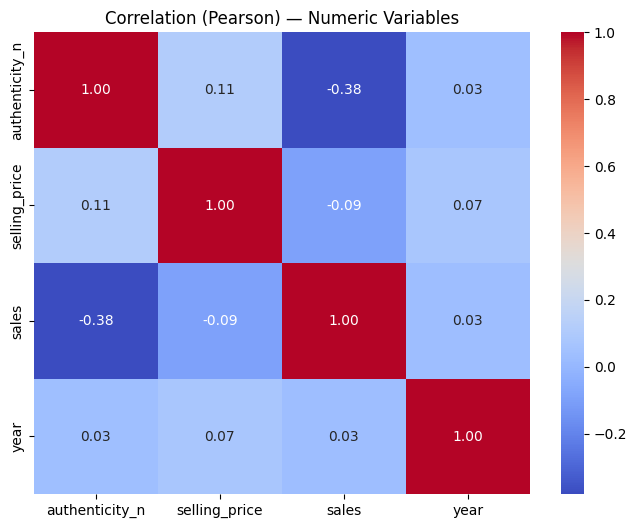

In [32]:
# SECTION 2 — Correlation Matrix (numeric features)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False)
    plt.title("Correlation (Pearson) — Numeric Variables")
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


Missingness summary:


,missing_count,missing_pct
figure,0,0.0
authenticity_n,0,0.0
selling_price,0,0.0
sales,0,0.0
condition,0,0.0
character_type,0,0.0
year,0,0.0


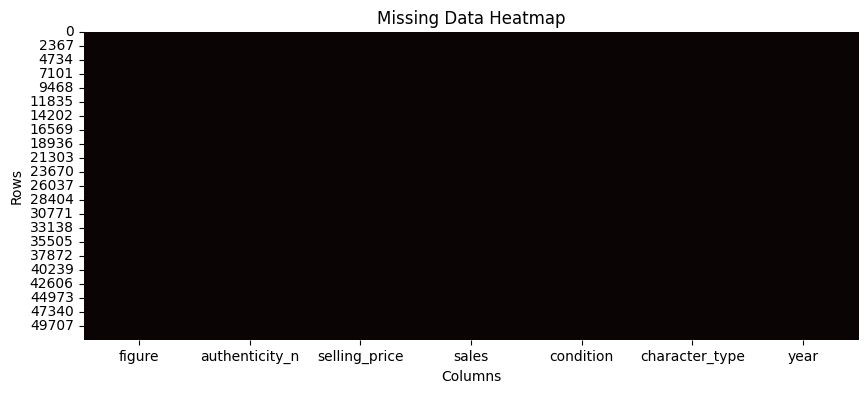

In [33]:
# SECTION 2 — Missingness overview
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": (missing_counts / len(df) * 100).round(2)
})
print("Missingness summary:")
display(missing_df)

# Visualize as heatmap
plt.figure(figsize=(10,4))
sns.heatmap(df.isna(), cbar=False, cmap="mako")
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


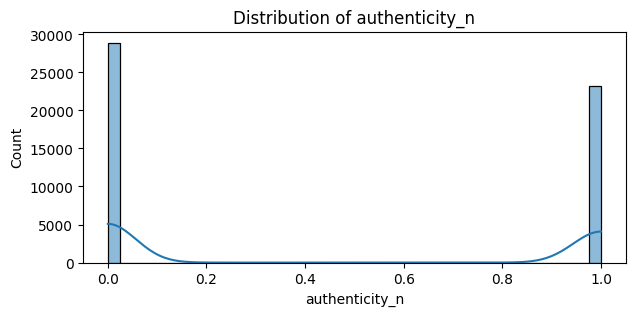

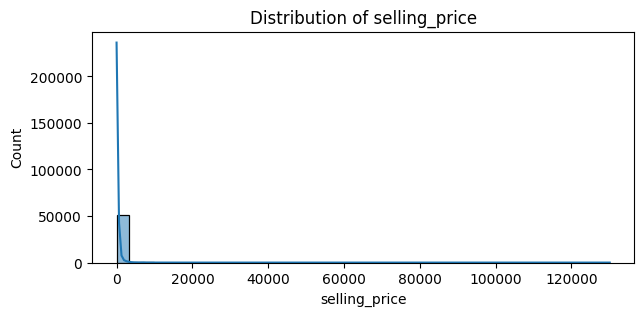

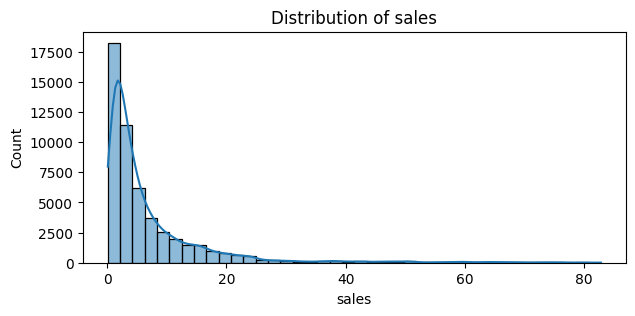

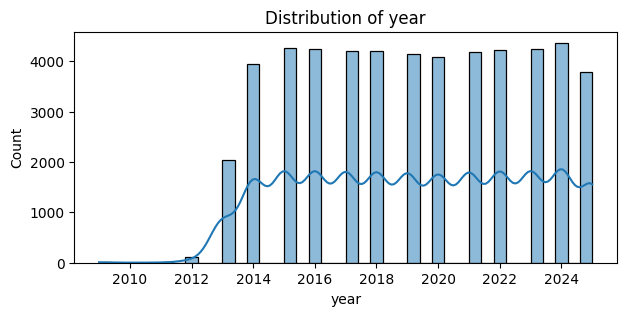

In [34]:
# SECTION 2 — Quick numeric distribution overview
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    plt.figure(figsize=(7,3))
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


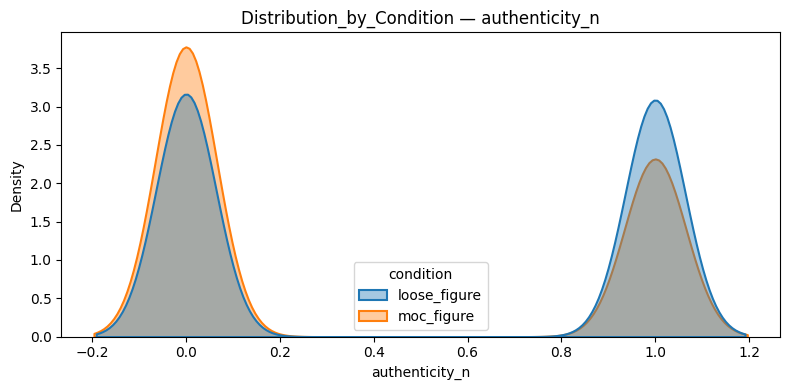

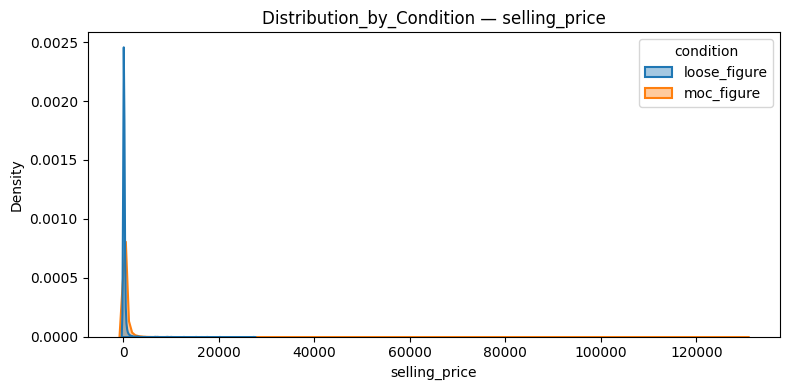

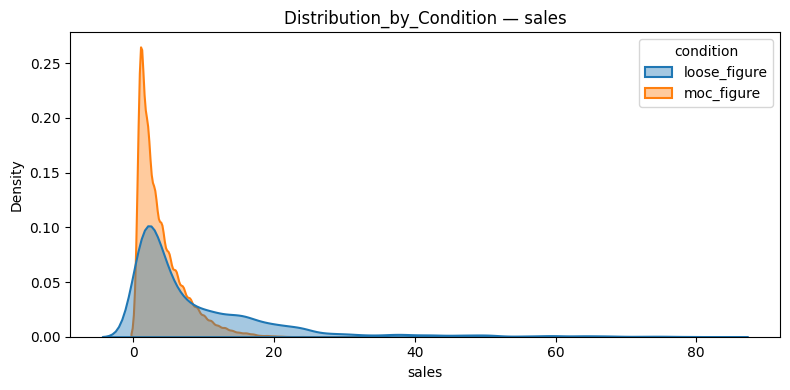

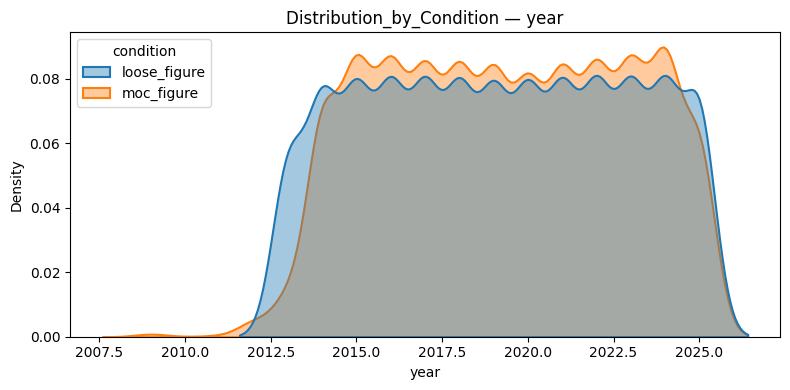

In [36]:
# --- Distribution_by_Condition ---
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=df,
        x=col,
        hue="condition",
        common_norm=False,
        fill=True,
        alpha=0.4,
        linewidth=1.5
    )
    plt.title(f"Distribution_by_Condition — {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_54630/3495880258.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


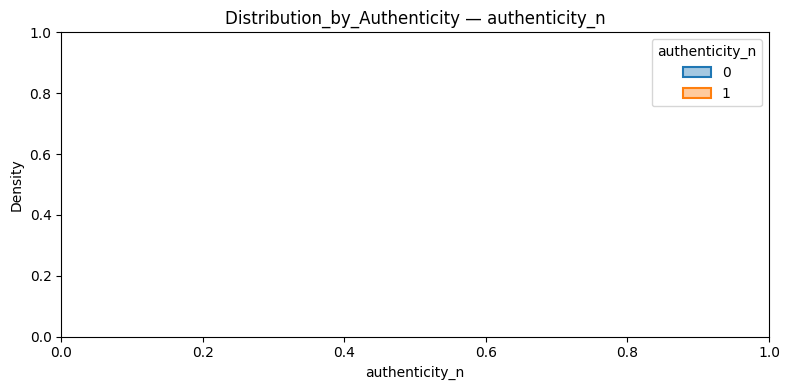

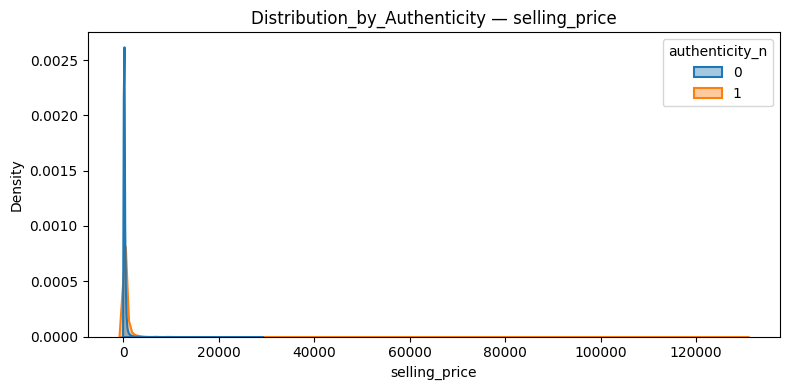

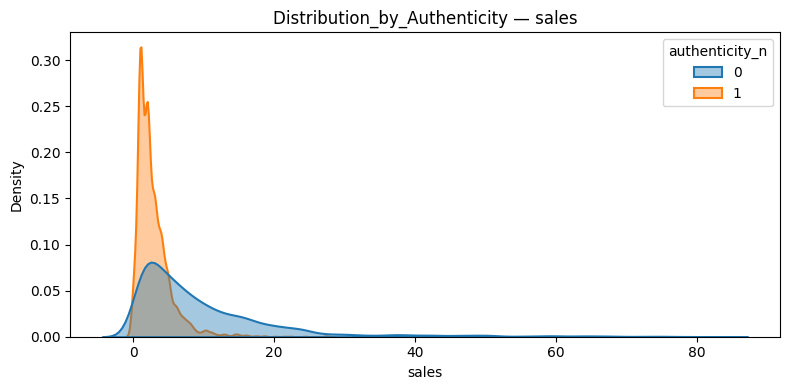

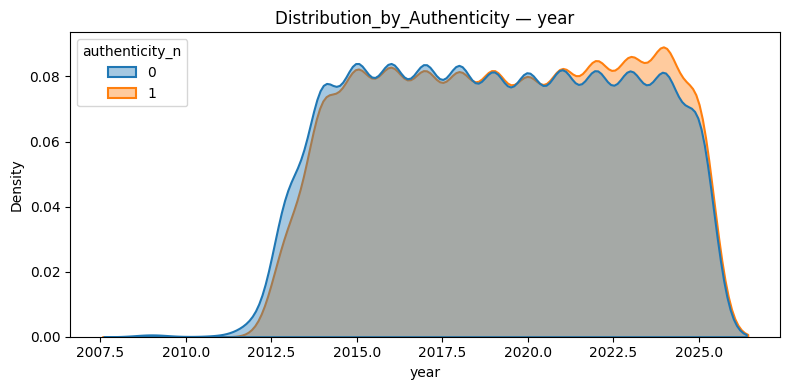

In [37]:
# --- Distribution_by_Authenticity ---
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=df,
        x=col,
        hue="authenticity_n",
        common_norm=False,
        fill=True,
        alpha=0.4,
        linewidth=1.5
    )
    plt.title(f"Distribution_by_Authenticity — {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_54630/315146474.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_54630/315146474.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Condition | Authenticity", bbox_to_anchor=(1.05, 1), loc='upper left')


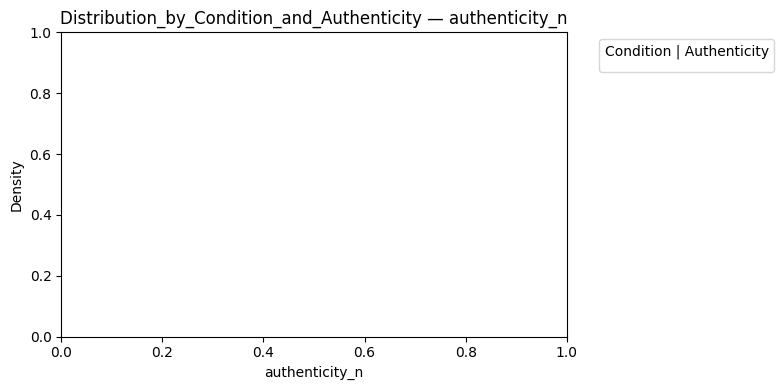

/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_54630/315146474.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Condition | Authenticity", bbox_to_anchor=(1.05, 1), loc='upper left')


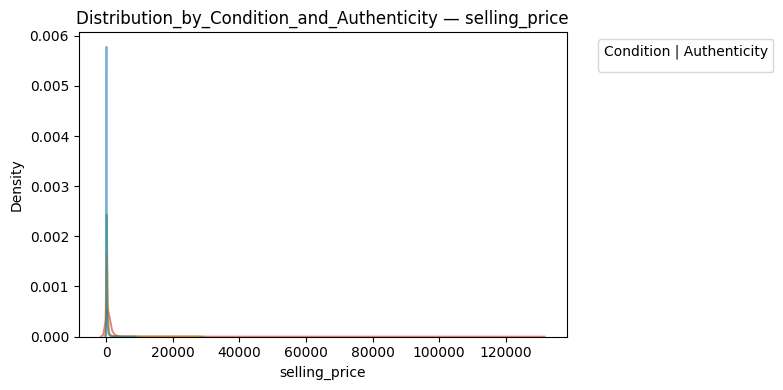

/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_54630/315146474.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Condition | Authenticity", bbox_to_anchor=(1.05, 1), loc='upper left')


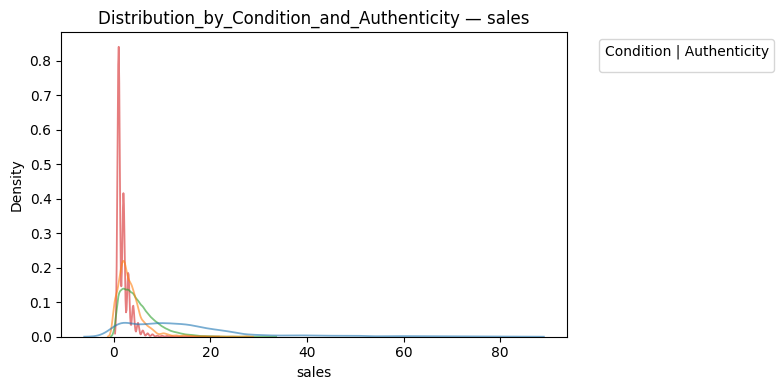

/var/folders/xg/2vlsx6js7zl68g4305b178yw0000gn/T/ipykernel_54630/315146474.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Condition | Authenticity", bbox_to_anchor=(1.05, 1), loc='upper left')


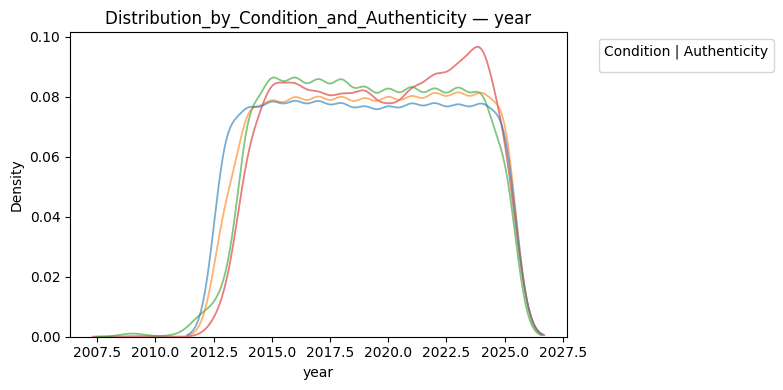

In [38]:
# --- Distribution_by_Condition_and_Authenticity ---
df["condition_auth"] = df["condition"].astype(str) + " | auth=" + df["authenticity_n"].astype(str)

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        data=df,
        x=col,
        hue="condition_auth",
        common_norm=False,
        alpha=0.6,
        linewidth=1.3
    )
    plt.title(f"Distribution_by_Condition_and_Authenticity — {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend(title="Condition | Authenticity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [39]:
def plot_distribution_by_condition(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        plt.figure(figsize=(8,4))
        sns.kdeplot(data=df, x=col, hue="condition", common_norm=False, fill=True, alpha=0.4, linewidth=1.5)
        plt.title(f"Distribution_by_Condition — {col}")
        plt.tight_layout()
        plt.show()

def plot_distribution_by_authenticity(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        plt.figure(figsize=(8,4))
        sns.kdeplot(data=df, x=col, hue="authenticity_n", common_norm=False, fill=True, alpha=0.4, linewidth=1.5)
        plt.title(f"Distribution_by_Authenticity — {col}")
        plt.tight_layout()
        plt.show()

def plot_distribution_by_condition_and_authenticity(df):
    df = df.copy()
    df["condition_auth"] = df["condition"].astype(str) + " | auth=" + df["authenticity_n"].astype(str)
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        plt.figure(figsize=(8,4))
        sns.kdeplot(data=df, x=col, hue="condition_auth", common_norm=False, alpha=0.6, linewidth=1.3)
        plt.title(f"Distribution_by_Condition_and_Authenticity — {col}")
        plt.tight_layout()
        plt.show()
